<font color='green'> 
**Kodluyoruz - Data Science for Public Good - Decision Tree Homework**
    
Kaggle'daki [House Prices](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) datası üzerinde preprocessing ve decision tree ile model kurma işlemleri gerçekleştirdim. 
</font>

### İzlediğim Adımlar

**1. PREPROCESSING**

* Kütüphaneleri import ettim.
* Data frame'i dosyadan okudum.
* İlk 5 satırı göster dediğimde tüm kolonları göremediğimden "display_all" fonksiyonunu yazdım.
* Kaggle Root Mean Squared Log Error (RMSLE) istediğinden target series olan SalePrice sütunun log'unu aldım. RMSE hesapladığımda bana RMSLE'yi verecek. 
* Test size'ın boyutunu öğrenmek için test data frame'i de okudum. 
* Train setimi evlerin satılış tarihine göre sıraladım. 
* Test setimi de evlerin satılış tarihine göre sıraladım. Hangi seneler var diye baktım. 
* Tüm train data setinde random forest uygulamaya çalıştım. Fakat data setimde string tipinde veriler olduğu için hata verdi. Bu yüzden string verilerimi nümerik verilere dönüştürdüm. 
* Dataframe'in son halini feather ile dosyaya kaydettim, sonra oradan okuyup işlemime devam ettim. 
* Nümerik değerler içeren sütunlarımda eğer null değerler varsa ayrı bir sütun oluşturmasını ve buraya null olup olmadığı bilgisini yazmasını sağladım. Sonrasında da asıl sütunu sütundaki değerlerin medianıyla doldurmasını sağladım.
* Eğer columnların içerisinde tipi nümerik değerde olmayan varsa (yani kategorik değerse) kodları -1'den değil de 0'dan başlasın diye numericalize () fonksiyonunu yazdım. 
* fix_missing, numericalize fonksiyonlarını çalışTırmak ve data frame'i x, y değerlerine ayırmak için proc_df fonksiyonunu yazdım.
* Tüm data setimde random forest çalıştırıyorum. 
* 1459 test verim var. Test verilerimin feature importance'ına bakıp ona göre trainden validation ayırmalıyım. Şu an için feature importance'a bakmadan 460 verim validationa, 1000 veri traine kalacak şekilde traini böldüm.

**2. RANDOM SAMPLING İLE MODELİ KURMAK**

* Random olarak istediğim sayıda sample almak için fonksiyon yazdım. 
* get_sample() fonksiyonunu çalıştırmak ve sample data frame'imi x, y değerlerine ayırmak için sample_proc_df fonksiyonunu yazdım. 
* Root Mean Square Error hesaplamak için fonksiyon yazdım. Daha sonra RMSE'yi ve R^2'yi yazdırmak için bir fonksiyon yazdım. 
* 200 rowluk sample train setimi önce tek bir ağaçla çalıştırıyorum. 
* Tek ağaçla çalıştırdığım modelde o ağacımı çizdiriyorum. 
* Soru sayısını (max_depth) kısıtlamadan ağacımı çizdiriyorum. Leaf nodlarda 1 veri kalana kadar soru soruyor. 
* Tek ağaç kullanınca veriyi ezberliyor. Train setimin accuracy'si yüksek olurken validation setiminki düşük oluyor. Bu sorunu gidermek için birbiriyle korole olmayan farklı modeller oluşturuyorum. 
* Ağaç sayısını, kaç kez soru soracağı bilgisini (max_depth), bootstrapi (false olarak) değiştirip farklı modeller  deniyorum.
* Her bir ağacın tahminini, tahminlerin ortalamasını ve gerçek y_sample_valid değerimi görmek için array tanımlıyorum. 
* Her bir ağacın etkisini görmek için grafik çizdiriyorum.  
* 200 adet ağaçla bootstrap özelliği de True olarak modelimin skorumu hesaplıyorum.
* 200 verilik sample train setimin oob skorunu hesaplamak istiyorum. Öncelikle bunun için oob skorunu hesaplayıp yazdıracağım print_oob_score_sample() fonksiyonunu yazdım. Daha sonra modelimi çaıştırıyorum. 

**3. SUBSAMPLING İLE MODELİ KURMAK**

* 1000 veriden almış olduğum 300 veri üzerinde bootstrap yapmak yerine 1000 verilik tüm data setimde 300'er 300'er veri setleri alıp modelimi eğitmek istiyorum. 
* Train setimi daha önce train ve validation olarak ayırmıştım. 
* Subsampling modelimde kullanacağım x_train, y_train değerleri için tekrar skor yazdırma fonksiyonu tanımlıyorum.
* Random forest'in bootstrap sample alma görevini tanımladığı fonksiyonda değişiklik yapacağım. 
* Kaç ağaçtan sonra bir şey farketmediğini görmek için skorların grafiğini çizdiriyorum.
* min_sample_leaf son node'da kaç veri bırakacağımızı söylediğimiz bir parametreydi. Bu parametrede değişiklik yapıyorum.
* max_features kaç sütuna soru soracağı bilgisini verdiğimiz parametreydi. Bu parametrede değişiklik yapıyorum.

### <font color='blue'>**1. PREPROCESSING**</font>

#### Kütüphaneleri import ettim.

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

In [3]:
import pandas as pd
import numpy as np
import math

#### Data frame'i dosyadan okudum.

In [4]:
PATH="data/" 

In [5]:
df_raw=pd.read_csv(f'{PATH}train.csv',low_memory=False)

#### İlk 5 satırı göster dediğimde tüm kolonları göremediğimden "display_all" fonksiyonunu yazdım.

In [26]:
df_raw.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [27]:
df_raw.shape

(1460, 81)

In [28]:
def display_all(df):
    with pd.option_context("display.max_rows",1500,"display.max_columns",100):
        display(df)

In [29]:
display_all(df_raw.tail())

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,GasA,Gd,Y,FuseA,1078,0,0,1078,1,0,1,0,2,1,Gd,5,Typ,0,NaN,Attchd,1950.0,Unf,1,240,TA,TA,Y,366,0,112,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125
1459,1460,20,RL,75.0,9937,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,5,6,1965,1965,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,CBlock,TA,TA,No,BLQ,830,LwQ,290,136,1256,GasA,Gd,Y,SBrkr,1256,0,0,1256,1,0,1,1,3,1,TA,6,Typ,0,NaN,Attchd,1965.0,Fin,1,276,TA,TA,Y,736,68,0,0,0,0,NaN,NaN,NaN,0,6,2008,WD,Normal,147500


In [30]:
display_all(df_raw.tail().T)

,1455,1456,1457,1458,1459
Id,1456,1457,1458,1459,1460
MSSubClass,60,20,70,20,20
MSZoning,RL,RL,RL,RL,RL
LotFrontage,62,85,66,68,75
LotArea,7917,13175,9042,9717,9937
Street,Pave,Pave,Pave,Pave,Pave
Alley,NaN,NaN,NaN,NaN,NaN
LotShape,Reg,Reg,Reg,Reg,Reg
LandContour,Lvl,Lvl,Lvl,Lvl,Lvl
Utilities,AllPub,AllPub,AllPub,AllPub,AllPub


In [31]:
display_all(df_raw.describe(include='all').T)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Id,1460,NaN,NaN,NaN,730.5,421.61,1,365.75,730.5,1095.25,1460
MSSubClass,1460,NaN,NaN,NaN,56.8973,42.3006,20,20,50,70,190
MSZoning,1460,5,RL,1151,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LotFrontage,1201,NaN,NaN,NaN,70.05,24.2848,21,59,69,80,313
LotArea,1460,NaN,NaN,NaN,10516.8,9981.26,1300,7553.5,9478.5,11601.5,215245
Street,1460,2,Pave,1454,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Alley,91,2,Grvl,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LotShape,1460,4,Reg,925,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LandContour,1460,4,Lvl,1311,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Utilities,1460,2,AllPub,1459,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Kaggle Root Mean Squared Log Error (RMSLE) istediğinden target series olan SalePrice sütunun log'unu aldım. RMSE hesapladığımda bana RMSLE'yi verecek. 

In [32]:
df_raw["SalePrice"]=np.log(df_raw.SalePrice)

In [33]:
df_raw["SalePrice"]

0       12.247694
1       12.109011
2       12.317167
3       11.849398
4       12.429216
          ...    
1455    12.072541
1456    12.254863
1457    12.493130
1458    11.864462
1459    11.901583
Name: SalePrice, Length: 1460, dtype: float64

#### Test size'ın boyutunu öğrenmek için test data frame'i de okudum. 

In [34]:
df_test=pd.read_csv(f'{PATH}test.csv',low_memory=False,parse_dates=["YearBuilt","YearRemodAdd","YrSold"])

In [35]:
df_test.shape

(1459, 80)

#### Train setimi evlerin satılış tarihine göre sıraladım. 

In [36]:
df_raw.sort_values(by=['YrSold'], inplace=True)

In [37]:
df_raw.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
781,782,60,RL,65.0,7153,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2006,WD,Normal,12.077671
1219,1220,160,RM,21.0,1680,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,11.424094
281,282,20,FV,60.0,7200,Pave,Pave,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2006,New,Partial,12.128111
569,570,90,RL,NaN,7032,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2006,WD,Normal,11.820116
1220,1221,20,RL,66.0,7800,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,11,2006,WD,Abnorml,11.652687


In [38]:
df_raw.tail()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
353,354,30,RM,60.0,8520,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,11.570251
1322,1323,60,RL,107.0,10186,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,12.154779
162,163,20,RL,95.0,12182,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2010,New,Partial,12.301383
158,159,60,FV,100.0,12552,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdWo,NaN,0,5,2010,WD,Normal,12.448627
1284,1285,50,RL,50.0,9638,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2010,WD,Normal,12.037654


#### Test setimi de evlerin satılış tarihine göre sıraladım. Hangi seneler var diye baktım. 

In [39]:
df_test.sort_values(by="YrSold",inplace=True)

In [40]:
# display_all(df_test)

#### Tüm train data setinde random forest uygulamaya çalıştım. Fakat data setimde string tipinde veriler olduğu için hata verdi. Bu yüzden string verilerimi nümerik verilere dönüştürdüm. 

In [41]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(df_raw.drop('SalePrice', axis=1), df_raw.SalePrice)

ValueError: could not convert string to float: 'RL'

In [42]:
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

In [43]:
def train_cats(df):
    for n,c in df.items(): 
        if is_string_dtype(c): 
            df[n] = c.astype("category").cat.as_ordered()  

Kategoriye çevirdiğimde kategorik verilerimin kodu tüm veri setlerimde aynı olmalı. Burada validation setini henüz ayırmamıştım. Bu yüzden bunu ayrıca validation setime uygulamama gerek yok. Ama uygulamam gerekseydi aşağıdaki kodu yazacaktım. 

`def apply_cats(df, train):
    for n, c in df.items():
        if train[n].dtype == "category": 
            df[n] = pd.Categorical(c, categories = train[n].cat.categories, ordered = True)`

In [44]:
df = df_raw.copy()

In [45]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
781,782,60,RL,65.0,7153,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2006,WD,Normal,12.077671
1219,1220,160,RM,21.0,1680,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,11.424094
281,282,20,FV,60.0,7200,Pave,Pave,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2006,New,Partial,12.128111
569,570,90,RL,NaN,7032,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2006,WD,Normal,11.820116
1220,1221,20,RL,66.0,7800,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,11,2006,WD,Abnorml,11.652687


In [46]:
df["MSZoning"]  # Veri tipi şu an object görünüyor. 

781     RL
1219    RM
281     FV
569     RL
1220    RL
        ..
353     RM
1322    RL
162     RL
158     FV
1284    RL
Name: MSZoning, Length: 1460, dtype: object

In [47]:
train_cats(df)  # fonksiyonu uyguladım.

In [48]:
df["MSZoning"].dtype# veri tipi category oldu.

CategoricalDtype(categories=['C (all)', 'FV', 'RH', 'RL', 'RM'], ordered=True)

#### Dataframe'in son halini feather ile dosyaya kaydettim, sonra oradan okuyup işlemime devam ettim. 

In [49]:
df=df.reset_index()

In [50]:
import os

os.makedirs('tmp',exist_ok=True)
df.to_feather('tmp\sale1')

# Çalışmayabiliyor bazen, df=df.reset_index() bunu uygula.

In [51]:
df = pd.read_feather("tmp/sale1")

In [52]:
df_raw.shape

(1460, 81)

#### Nümerik değerler içeren sütunlarımda eğer null değerler varsa ayrı bir sütun oluşturmasını ve buraya null olup olmadığı bilgisini yazmasını sağladım. Sonrasında da asıl sütunu sütundaki değerlerin medianıyla doldurmasını sağladım.

In [53]:
display_all(df.isnull().sum().sort_index())

1stFlrSF            0
2ndFlrSF            0
3SsnPorch           0
Alley            1369
BedroomAbvGr        0
BldgType            0
BsmtCond           37
BsmtExposure       38
BsmtFinSF1          0
BsmtFinSF2          0
BsmtFinType1       37
BsmtFinType2       38
BsmtFullBath        0
BsmtHalfBath        0
BsmtQual           37
BsmtUnfSF           0
CentralAir          0
Condition1          0
Condition2          0
Electrical          1
EnclosedPorch       0
ExterCond           0
ExterQual           0
Exterior1st         0
Exterior2nd         0
Fence            1179
FireplaceQu       690
Fireplaces          0
Foundation          0
FullBath            0
Functional          0
GarageArea          0
GarageCars          0
GarageCond         81
GarageFinish       81
GarageQual         81
GarageType         81
GarageYrBlt        81
GrLivArea           0
HalfBath            0
Heating             0
HeatingQC           0
HouseStyle          0
Id                  0
KitchenAbvGr        0
KitchenQua

In [54]:
def fix_missing(df, col, name):
    if is_numeric_dtype(col): 
        if pd.isnull(col).sum(): 
            df[name+"_na"] = pd.isnull(col) 
            df[name] = col.fillna(col.median())

#### Eğer columnların içerisinde tipi nümerik değerde olmayan varsa (yani kategorik değerse) kodları -1'den değil de 0'dan başlasın diye numericalize () fonksiyonunu yazdım. 

In [59]:
def numericalize(df, col, name):
    if not is_numeric_dtype(col):
        df[name] = col.cat.codes+1
        
        # nümerik değere dönüştürmüş olduk. 

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 82 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   index          1460 non-null   int64   
 1   Id             1460 non-null   int64   
 2   MSSubClass     1460 non-null   int64   
 3   MSZoning       1460 non-null   category
 4   LotFrontage    1201 non-null   float64 
 5   LotArea        1460 non-null   int64   
 6   Street         1460 non-null   category
 7   Alley          91 non-null     category
 8   LotShape       1460 non-null   category
 9   LandContour    1460 non-null   category
 10  Utilities      1460 non-null   category
 11  LotConfig      1460 non-null   category
 12  LandSlope      1460 non-null   category
 13  Neighborhood   1460 non-null   category
 14  Condition1     1460 non-null   category
 15  Condition2     1460 non-null   category
 16  BldgType       1460 non-null   category
 17  HouseStyle     1460 non-null   ca

In [56]:
df.head()

,index,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,781,782,60,RL,65.0,7153,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,7,2006,WD,Normal,12.077671
1,1219,1220,160,RM,21.0,1680,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,11.424094
2,281,282,20,FV,60.0,7200,Pave,Pave,Reg,Lvl,...,0,NaN,NaN,NaN,0,5,2006,New,Partial,12.128111
3,569,570,90,RL,NaN,7032,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,12,2006,WD,Normal,11.820116
4,1220,1221,20,RL,66.0,7800,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,11,2006,WD,Abnorml,11.652687


#### fix_missing, numericalize fonksiyonlarını çalıtşırmak ve data frame'i x, y değerlerine ayırmak için proc_df fonksiyonunu yazdım.

In [60]:
def proc_df(df, y_fld,subset=None):
    
    for n, c in df.items():
        fix_missing(df, c, n)
        
        
    for n, c in df.items():
        numericalize(df, c, n)
        
    
    x=df.copy()
    
    y = x[y_fld].values
    x.drop([y_fld], axis = 1, inplace = True) 
    
    
    res = [x, y]
    

    return res


In [61]:
x, y = proc_df(df, 'SalePrice')

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 85 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   index           1460 non-null   int64  
 1   Id              1460 non-null   int64  
 2   MSSubClass      1460 non-null   int64  
 3   MSZoning        1460 non-null   int8   
 4   LotFrontage     1460 non-null   float64
 5   LotArea         1460 non-null   int64  
 6   Street          1460 non-null   int8   
 7   Alley           1460 non-null   int8   
 8   LotShape        1460 non-null   int8   
 9   LandContour     1460 non-null   int8   
 10  Utilities       1460 non-null   int8   
 11  LotConfig       1460 non-null   int8   
 12  LandSlope       1460 non-null   int8   
 13  Neighborhood    1460 non-null   int8   
 14  Condition1      1460 non-null   int8   
 15  Condition2      1460 non-null   int8   
 16  BldgType        1460 non-null   int8   
 17  HouseStyle      1460 non-null   i

In [63]:
df.head()

,index,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,...,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,LotFrontage_na,MasVnrArea_na,GarageYrBlt_na
0,781,782,60,4,65.0,7153,2,0,4,4,...,0,0,7,2006,9,5,12.077671,False,False,False
1,1219,1220,160,5,21.0,1680,2,0,4,4,...,0,0,4,2006,9,1,11.424094,False,False,True
2,281,282,20,2,60.0,7200,2,2,4,4,...,0,0,5,2006,7,6,12.128111,False,False,False
3,569,570,90,4,69.0,7032,2,0,1,4,...,0,0,12,2006,9,5,11.820116,True,False,False
4,1220,1221,20,4,66.0,7800,2,0,1,4,...,0,0,11,2006,9,1,11.652687,False,False,False


In [64]:
x.head()

,index,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,...,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,LotFrontage_na,MasVnrArea_na,GarageYrBlt_na
0,781,782,60,4,65.0,7153,2,0,4,4,...,0,0,0,7,2006,9,5,False,False,False
1,1219,1220,160,5,21.0,1680,2,0,4,4,...,0,0,0,4,2006,9,1,False,False,True
2,281,282,20,2,60.0,7200,2,2,4,4,...,0,0,0,5,2006,7,6,False,False,False
3,569,570,90,4,69.0,7032,2,0,1,4,...,0,0,0,12,2006,9,5,True,False,False
4,1220,1221,20,4,66.0,7800,2,0,1,4,...,0,0,0,11,2006,9,1,False,False,False


In [65]:
y

array([12.07767093, 11.42409425, 12.1281111 , ..., 12.30138283,
       12.44862659, 12.03765399])

#### Tüm data setimde random forest çalıştırıyorum. 

In [143]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(x, y)
m.score(x,y) 

0.9830200063236202

Skorum 0.9830200063236202 çıktı. 1'e yakın ama overfit olmuş olabilir. Bu yüzden modelimizi denemek için validation set oluşturuyoruz. 

#### 1459 test verim var. Test verilerimin feature importance'ına bakıp ona göre trainden validation ayırmalıyım. Şu an için feature importance'a bakmadan 460 verim validationa, 1000 veri traine kalacak şekilde traini böldüm.

In [66]:
def split_train_val(df,n): 
    
    return df[:n].copy(), df[n:].copy()

In [67]:
n_valid = 460  
n_train = len(df)-n_valid
df_train, df_valid = split_train_val(df, n_train)
x_train, x_valid = split_train_val(x, n_train)
y_train, y_valid = split_train_val(y, n_train)

df_train.shape, df_valid.shape, x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((1000, 85), (460, 85), (1000, 84), (1000,), (460, 84), (460,))

### <font color='blue'>**2. RANDOM SAMPLING İLE MODELİ KURMAK**</font>

#### Random olarak istediğim sayıda sample almak için fonksiyon yazdım. 

Bu fonksiyon data frame'in uzunluğundan belirttiğim sayıya kadar yani 1500 uzunluğundaysa data frame 0,1,2.....1499. Random olarak bu sayıları seçip gösterecek 2,128,345,23,5..... olarak. Bu sayılardan n tanesini istediğimde İlk n taneyi getirecek. 5 dedim diyelim. 128,2,345,23,5. Sonra bunları sıralayacak. 2,5,23,128,345 olarak.

In [69]:
np.random.permutation(len(df))

array([ 828,  678, 1382, ..., 1112,  804, 1121])

In [70]:
np.random.permutation(len(df))[:5]

array([ 289,  998,  204, 1084, 1432])

In [71]:
sorted(np.random.permutation(len(df))[:5]) 

[329, 833, 855, 1069, 1235]

In [72]:
a=sorted(np.random.permutation(len(df))[:5]) 

In [73]:
df.iloc[a]

,index,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,...,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,LotFrontage_na,MasVnrArea_na,GarageYrBlt_na
71,247,248,20,4,75.0,11310,2,0,4,4,...,0,0,6,2006,9,5,11.849398,False,False,False
166,376,377,85,4,57.0,8846,2,0,1,4,...,0,0,7,2006,9,5,11.904968,False,False,False
622,1184,1185,20,4,50.0,35133,1,0,4,4,...,0,0,5,2007,9,5,12.137258,False,False,False
721,1118,1119,80,4,85.0,13825,2,0,4,4,...,0,0,12,2008,9,5,11.849398,False,False,False
728,1037,1038,60,4,69.0,9240,2,0,4,4,...,0,0,9,2008,9,5,12.567237,True,False,False


In [74]:
def get_sample(df,n):
    
    idxs = sorted(np.random.permutation(len(df))[:n]) 
    return df.iloc[idxs].copy()

Train data setimden sample alıyorum. 

In [75]:
df.head()

,index,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,...,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,LotFrontage_na,MasVnrArea_na,GarageYrBlt_na
0,781,782,60,4,65.0,7153,2,0,4,4,...,0,0,7,2006,9,5,12.077671,False,False,False
1,1219,1220,160,5,21.0,1680,2,0,4,4,...,0,0,4,2006,9,1,11.424094,False,False,True
2,281,282,20,2,60.0,7200,2,2,4,4,...,0,0,5,2006,7,6,12.128111,False,False,False
3,569,570,90,4,69.0,7032,2,0,1,4,...,0,0,12,2006,9,5,11.820116,True,False,False
4,1220,1221,20,4,66.0,7800,2,0,1,4,...,0,0,11,2006,9,1,11.652687,False,False,False


#### get_sample() fonksiyonunu çalıştırmak ve sample data frame'imi x, y değerlerine ayırmak için sample_proc_df fonksiyonunu yazdım. 

In [78]:
def sample_proc_df(df, y_fld,subset):
        
    df_sample = get_sample(df, subset)
    x=df_sample.copy()
    
    y = x[y_fld].values
    x.drop([y_fld], axis = 1, inplace = True) 
    
    res = [x, y]
    

    return res

# Yukarıdaki proc_df'i de çalıştırabilirdim.

In [79]:
X_sample, Y_sample = sample_proc_df(df_train,"SalePrice",300)
X_sample_train, X_sample_valid = split_train_val(X_sample, 200)
Y_sample_train, Y_sample_valid = split_train_val(Y_sample, 200)

#### Root Mean Square Error hesaplamak için fonksiyon yazdım. Daha sonra RMSE'yi ve R^2'yi yazdırmak için bir fonksiyon yazdım. 

In [80]:
def rmse(x,y): # kendimiz tanımladık root mean square erroru.
    return math.sqrt(((x-y)**2).mean())

In [81]:
def print_score_sample (m):
    
    print(f"RMSE of train set {rmse(m.predict(X_sample_train), Y_sample_train)}")  
    print(f"RMSE of validation set {rmse(m.predict(X_sample_valid), Y_sample_valid)}") 
    print(f"R^2 of train set {m.score(X_sample_train, Y_sample_train)}")  
    print(f"R^2 of validation set {m.score(X_sample_valid, Y_sample_valid)}")

m.predict(X_train) model X_train'de çalıştığında tahmin ettiği y değerini döndürüyor. Bu y değeri ve Y_train değeri rmse fonksiyonun içerisine girdiğinde hata oranı hesaplanmış oluyor.  

#### 200 rowluk sample train setimi önce tek bir ağaçla çalıştırıyorum. 

In [83]:
m = RandomForestRegressor(n_estimators=1, max_depth=3,n_jobs=-1)
%time m.fit(X_sample_train, Y_sample_train)
print_score_sample(m)

Wall time: 107 ms
RMSE of train set 0.21590806900977602
RMSE of validation set 0.25138571420027117
R^2 of train set 0.6847969418861249
R^2 of validation set 0.540837743523223


#### Tek ağaçla çalıştırdığım modelde o ağacımı çizdiriyorum. 

In [85]:
estimator = m.estimators_[0]
estimator

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=3,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=971798069, splitter='best')

In [87]:
from sklearn import tree
import matplotlib.pyplot as plt

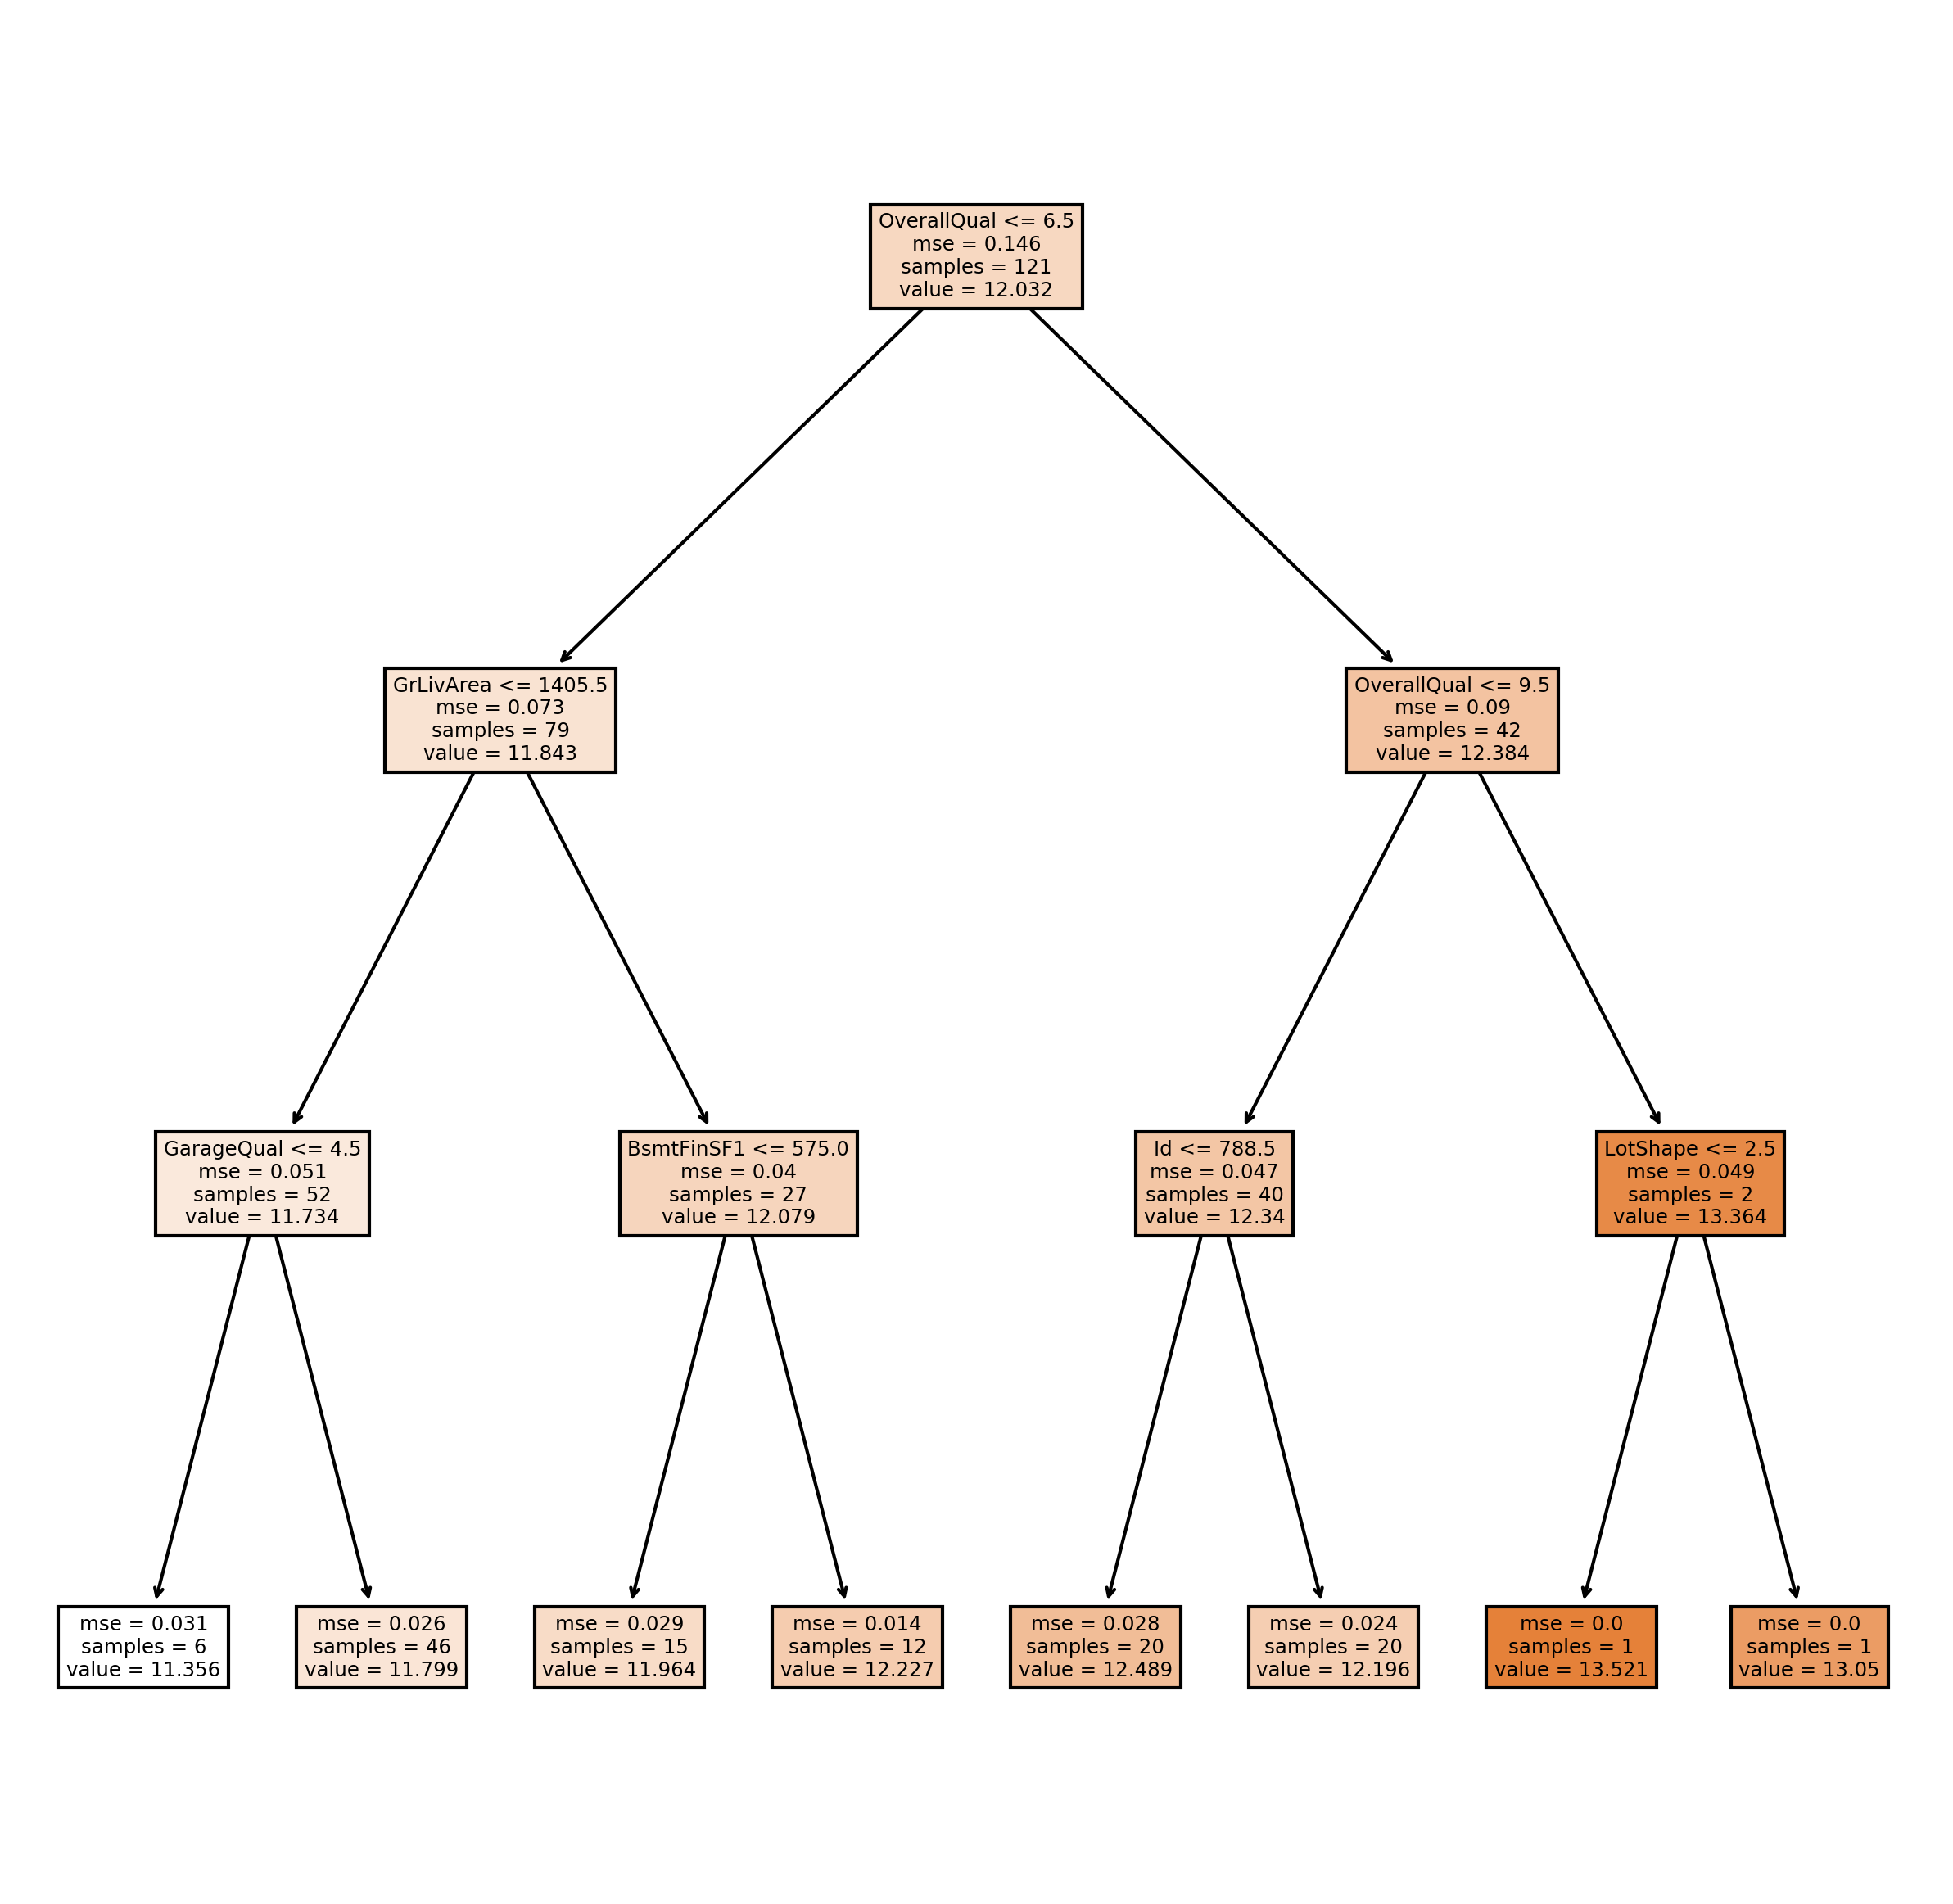

In [88]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (10,10), dpi=300)
tree.plot_tree(estimator, feature_names=df.columns,filled=True); 

#### Soru sayısını (max_depth) kısıtlamadan ağacımı çizdiriyorum. Leaf nodlarda 1 veri kalana kadar soru soruyor. 

In [92]:
m_2 = RandomForestRegressor(n_estimators=1,n_jobs=-1)
%time m_2.fit(X_sample_train, Y_sample_train)
print_score_sample(m_2)

Wall time: 106 ms
RMSE of train set 0.14541070115683621
RMSE of validation set 0.21585045784198845
R^2 of train set 0.8570298367828746
R^2 of validation set 0.6614748477409733


In [93]:
estimator_2 = m.estimators_[0]
estimator

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=3,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=971798069, splitter='best')

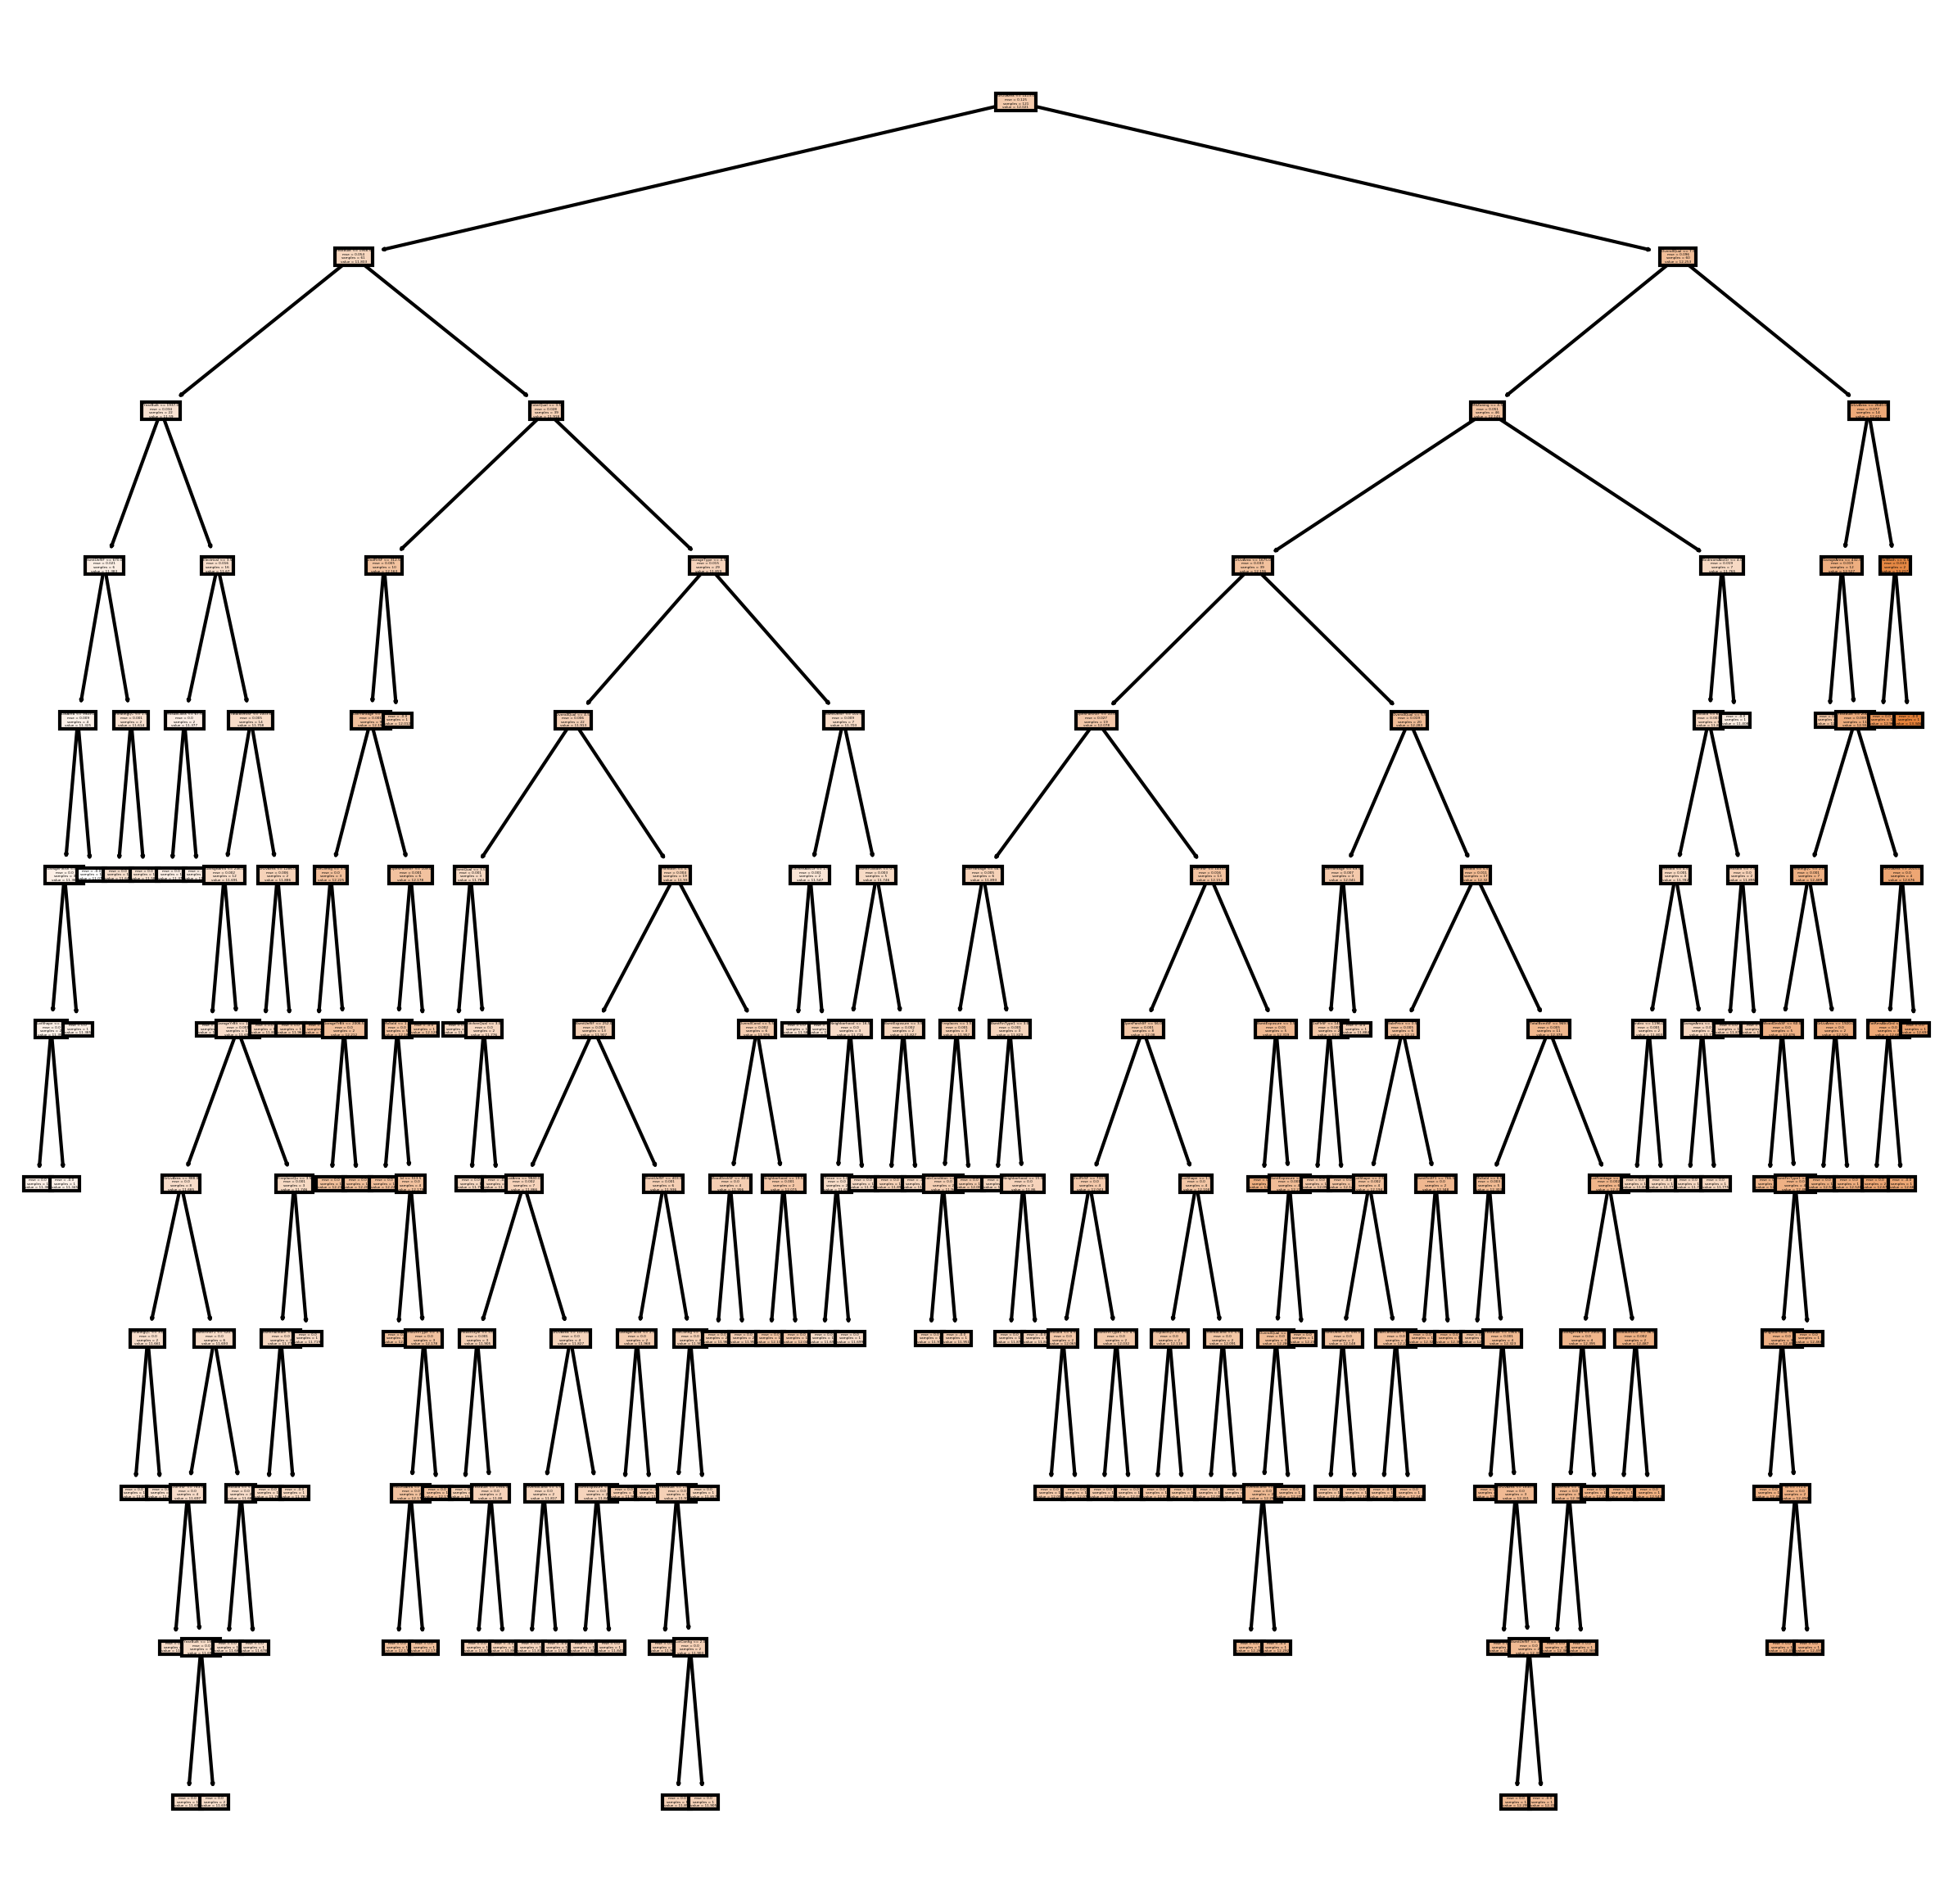

In [94]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (10,10), dpi=300)
tree.plot_tree(estimator_2, feature_names=df.columns,filled=True); 

#### Tek ağaç kullanınca veriyi ezberliyor. Train setimin accuracy'si yüksek olurken validation setiminki düşük oluyor. Bu sorunu gidermek için birbiriyle korole olmayan farklı modeller oluşturuyorum. 

**Amacımız:** Birbiriyle korole olmayan farklı modeller oluturmak ve onların tahminlerinin ortalamasını almak. 

**Sorun şu ki:** 10 tane farklı ağaç oluşturmak istediğimizi düşün hepsi aynı yerden bölecek node'ları, hepsi aynı model olacak.

**Bunu çözmek için:** Bu yüzden veriden subsetler alıyoruz, bu şekilde ağaçlar farklı subsetlerin patternlerini öğrenecek. 

Eğer verimizden sample almak için bootstrap uygularsak "populasyondan" sample almışız gibi olacak. Her subset farklı karakteristik özelliğe sahip olacak. Böylelikle her ağaç farklı patternler öğrenecek. 

In [95]:
# Default olarak boostrap ile 100 ağaç ile çalıştı.

m_default = RandomForestRegressor(n_jobs=-1)
%time m_default.fit(X_sample_train, Y_sample_train)
print_score_sample(m_default)

Wall time: 576 ms
RMSE of train set 0.05368147717272712
RMSE of validation set 0.15662072461234994
R^2 of train set 0.9805149469853037
R^2 of validation set 0.8217689147304093


#### Ağaç sayısını, kaç kez soru soracağı bilgisini (max_depth), bootstrapi (false olarak) değiştirip farklı modeller  deniyorum.

In [97]:
m = RandomForestRegressor(bootstrap=False, n_jobs=-1)
%time m.fit(X_sample_train, Y_sample_train)
print_score_sample(m)

Wall time: 494 ms
RMSE of train set 3.2937271883914416e-05
RMSE of validation set 0.2249421097991849
R^2 of train set 0.9999999926645303
R^2 of validation set 0.6323568130748487


#### Her bir ağacın tahminini, tahminlerin ortalamasını ve gerçek y_sample_valid değerimi görmek için array tanımlıyorum. 

In [98]:
preds = np.array([t.predict(X_sample_valid) for t in m_default.estimators_]) 

In [99]:
preds

array([[12.1388639 , 11.8968264 , 12.66032792, ..., 12.21106019,
        11.9511804 , 11.98292909],
       [12.32829028, 12.21106019, 12.52452638, ..., 12.29910751,
        11.94145585, 11.1124479 ],
       [12.1388639 , 11.8277362 , 12.6181823 , ..., 12.03469103,
        11.9511804 , 11.3736634 ],
       ...,
       [12.09458227, 12.04355372, 12.55483688, ..., 12.1281111 ,
        11.96400108, 11.69524702],
       [12.13618652, 11.6127708 , 12.4292162 , ..., 12.22587527,
        11.94145585, 11.6483563 ],
       [12.13618652, 11.9511804 , 12.65985286, ..., 12.20573923,
        11.90496755, 11.94794938]])

In [100]:
preds.shape # random forestte default olarak 100 ağaç tanımlanıyor.

(100, 100)

In [103]:
preds[:,0], np.mean(preds[:,0]), Y_sample_valid[0]

(array([12.1388639 , 12.32829028, 12.1388639 , 12.16785143, 12.08953883,
        12.13618652, 12.1281111 , 12.09458227, 12.23027733, 12.22587527,
        12.32829028, 12.23027733, 12.22587527, 12.21106019, 12.13618652,
        12.32829028, 12.03171926, 12.32829028, 12.1281111 , 12.32385568,
        12.13618652, 12.24961095, 12.13618652, 12.23027733, 12.29910751,
        12.18280402, 12.13618652, 12.20918779, 12.32829028, 12.13618652,
        12.16785143, 12.32385568, 12.1281111 , 12.18280402, 12.32385568,
        12.00762171, 12.13618652, 12.13618652, 12.17921519, 12.20657252,
        12.01188092, 12.13618652, 12.13618652, 12.13618652, 12.1281111 ,
        12.01188092, 12.13618652, 12.1281111 , 12.13618652, 12.15451616,
        12.13618652, 12.26857785, 12.28765263, 12.13269518, 12.19551713,
        12.38421883, 12.33655251, 12.16785143, 12.03469103, 12.1281111 ,
        12.33655251, 12.32385568, 12.14153412, 12.29910751, 12.1388639 ,
        12.08953883, 12.13618652, 12.32385568, 12.0

Her ağaç için y[0] değerlerini, bu değerlerin ortalamasını ve gerçek y değerini yazdırmış oldum.

#### Her bir ağacın etkisini görmek için grafik çizdiriyorum.  

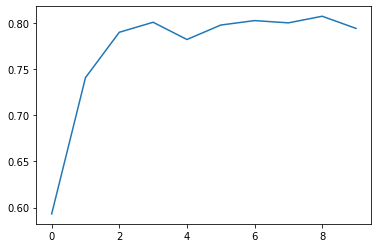

In [111]:
plt.plot([metrics.r2_score(Y_sample_valid, np.mean(preds[:i+1], axis=0)) for i in range(10)]);

# i+1'e kadar dedik i dahil olması için. 
# her ağaç için tahmini Y_sample_valid değerlerinin ortalamalarını alıyoruz. 
# gerçek y_valid değerleriyle r^2 score'unu hesaplıyoruz ve bu r^2 sonuçlarını çizdiriyoruz. 

#### 200 adet ağaçla bootstrap özelliği de True olarak modelimin skorumu hesaplıyorum.

In [112]:
m = RandomForestRegressor(n_estimators=200, n_jobs=-1)
%time m.fit(X_sample_train, Y_sample_train)
print_score_sample(m)

Wall time: 884 ms
RMSE of train set 0.05370423449458714
RMSE of validation set 0.15128851188659811
R^2 of train set 0.980498422789698
R^2 of validation set 0.8336982206958272


R^2 validation accuracy 0.63'ten 0.83'e çıktı. 

#### 200 verilik sample train setimin oob skorunu hesaplamak istiyorum. Öncelikle bunun için oob skorunu hesaplayıp yazdıracağım print_oob_score_sample() fonksiyonunu yazdım. Daha sonra modelimi çaıştırıyorum. 

In [87]:
def print_oob_score_sample(m):
    
    print(f"RMSE of train set {rmse(m.predict(X_sample_train), Y_sample_train)}") 
    print(f"R^2 of train set {m.score(X_sample_train, Y_sample_train)}")
    if hasattr(m, "oob_score_"):
        print(f"OOB score: {m.oob_score_}")

In [88]:
m = RandomForestRegressor(n_estimators=50, n_jobs=-1, oob_score=True) 
m.fit(X_sample_train, Y_sample_train)
print_oob_score_sample(m)

RMSE of train set 0.07188781566486593
R^2 of train set 0.9702940942242442
OOB score: 0.798317970780622


### <font color='blue'>**3. SUBSAMPLING İLE MODELİ KURMAK**</font>

#### 1000 veriden almış olduğum 300 veri üzerinde bootstrap yapmak yerine 1000 verilik tüm data setimde 300'er 300'er veri setleri alıp modelimi eğitmek istiyorum. 

Daha önce aşağıdaki gibi 300 veri sample almıştık ve modelimizi sadece bu 300 veri üzerinde eğitmiştik.

`X_sample, Y_sample = sample_proc_df(df_train,"SalePrice",300)
X_sample_train, X_sample_valid = split_train_val(X_sample, 200)
Y_sample_train, Y_sample_valid = split_train_val(Y_sample, 200)`

Ama ben modelimin sadece sample olarak almış olduğum 300 veriyi değil 1000 verilik data setimin tamamını görsün istiyorum. 

Sklearnde random forest çalıştırmak istediğimizde direkt 1000 verinin tamamını bütün olarak görüp bootstrap yapmaya kalkıyor. Fakat biz yeterince ağaç ile farklı farklı sample'lar alarak 1000 verinin tamamını görsün istiyoruz.Bunun için sklearnın fonksiyonunda değişiklik yapmamız gerekiyor.

#### Train setimi daha önce train ve validation olarak ayırmıştım. 

In [ ]:
# def split_train_val(df,n):
#    return df[:n].copy(), df[n:].copy()

In [ ]:
# n_valid = 460 
# n_train = len(df)-n_valid
# df_train, df_valid = split_train_val(df, n_train) 
# x_train, x_valid = split_train_val(x, n_train) 
# y_train, y_valid = split_train_val(y, n_train)

# df_train.shape, df_valid.shape, x_train.shape, y_train.shape, x_valid.shape, y_valid.shape 

#### Subsampling modelimde kullanacağım x_train, y_train değerleri için tekrar skor yazdırma fonksiyonu tanımlıyorum.

In [ ]:
def print_score_subsampling (m):
    
    print(f"RMSE of train set {rmse(m.predict(x_train), y_train)}")  
    print(f"RMSE of validation set {rmse(m.predict(x_valid), y_valid)}") 
    print(f"R^2 of train set {m.score(x_train, y_train)}")  
    print(f"R^2 of validation set {m.score(x_valid, y_valid)}")

#### Random forest'in bootstrap sample alma görevini tanımladığı fonksiyonda değişiklik yapacağım. 

In [119]:
from sklearn.ensemble import forest

C:\Users\aa\anaconda\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


Aşağıdaki fonksiyonu değiştireceğiz. Bootstrapten çıkaracağız fonksiyonu. 

In [ ]:
#def _generate_sample_indices(random_state, n_samples, n_samples_bootstrap):
#    """
#    Private function used to _parallel_build_trees function."""
#
#    random_instance = check_random_state(random_state)
#    sample_indices = random_instance.randint(0, n_samples, n_samples_bootstrap)
#
#    return sample_indices

In [120]:
def set_rf_samples(n):
    """ Changes Scikit learn's random forests to give each tree a random sample of
    n random rows.
    """
    forest._generate_sample_indices = (lambda rs, n_samples: 
                                       
        forest.check_random_state(rs).randint(0, n_samples, n))

Yukarıdaki fonksiyonu eski haline getirmenizi sağlayacak. 
Bootstrapten çıkardım sample'ı ama ben yine de bootstrap ile kullanmak istiyorsam reset_rf_samples() fonksiyonunu kullanabilirim.

In [ ]:
def reset_rf_samples():
    """ Undoes the changes produced by set_rf_samples.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n_samples))

Fonksiyon 300-300 subset almamızı sağlayacak.

In [125]:
set_rf_samples(300)

In [128]:
m_subsampling = RandomForestRegressor(n_jobs=-1)
%time m_subsampling.fit(x_train, y_train)
print_score_subsampling(m_subsampling)

Wall time: 1.24 s
RMSE of train set 0.05296601357024984
RMSE of validation set 0.15814706911167994
R^2 of train set 0.9814116021766983
R^2 of validation set 0.8591192469621064


In [132]:
len(m_subsampling.estimators_)

100

100 ağaçta çalıştırmış.

#### Kaç ağaçtan sonra bir şey farketmediğini görmek için skorların grafiğini çizdiriyorum. 

In [133]:
preds = np.array([t.predict(x_valid) for t in m_subsampling.estimators_]) 

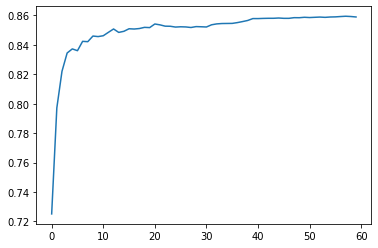

In [142]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(60)]);

40 ağaçtan sonra çok bir şey farketmemiş görünüyor.

#### min_sample_leaf son node'da kaç veri bırakacağımızı söylediğimiz bir parametreydi. Bu parametrede değişiklik yapıyorum.

In [146]:
m_subsampling.estimators_

[DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                       max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=666302970, splitter='best'),
 DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                       max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1814122044, splitter='best'),
 DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                       max_features='auto', max_leaf_nodes=None,
                       min_impuri

Normalde min_samples_leaf=3 müş. 5'e çıkartıp karşılaştırıyorum. 

In [147]:
m_subsampling = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, n_jobs=-1, oob_score=True)
m_subsampling.fit(x_train, y_train)
print_score_subsampling(m_subsampling)

RMSE of train set 0.07641809200400314
RMSE of validation set 0.16052048155847565
R^2 of train set 0.961306344224078
R^2 of validation set 0.8548589445611812


In [148]:
m_subsampling = RandomForestRegressor(n_estimators=40, min_samples_leaf=5, n_jobs=-1, oob_score=True)
m_subsampling.fit(x_train, y_train)
print_score_subsampling(m_subsampling)

RMSE of train set 0.09477281857220768
RMSE of validation set 0.16371173086798324
R^2 of train set 0.9404865705180094
R^2 of validation set 0.8490305859889002


#### max_features kaç sütuna soru soracağı bilgisini verdiğimiz parametreydi. Bu parametrede değişiklik yapıyorum.

Bu özellik sayesinde normalde 2.,3. sırada sorduğu soruları root'ta sorabilecek. Bu da modelimin verimden farklı patternler çıkarmasını sağlayacak. Tüm ağaçlarda aynı çıkarımda bulunarak ilerlemesini engelleyecek. 

In [149]:
m_subsampling = RandomForestRegressor(n_estimators=40, max_features=0.5, n_jobs=-1, oob_score=True)
m_subsampling.fit(x_train, y_train)
print_score_subsampling(m_subsampling)

RMSE of train set 0.05323597935314944
RMSE of validation set 0.16257517390407392
R^2 of train set 0.9812216305363742
R^2 of validation set 0.8511194983528887
